[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

We laid the foundations for this with streaming. 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user `approval`.

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Breakpoints for human approval

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

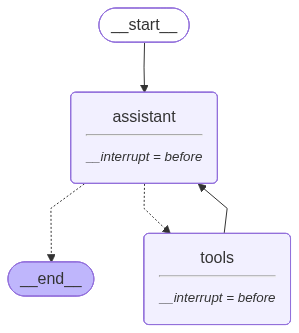

In [18]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools", "assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [20]:
state = graph.get_state(thread)
state.next

('assistant',)

In [21]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hTVBCNpx5fo3AdJdN43dfEqQ)
 Call ID: call_hTVBCNpx5fo3AdJdN43dfEqQ
  Args:
    a: 2
    b: 3


Now, lets bring these together with a specific user approval step that accepts user input.

In [24]:
thread = {"configurable": {"thread_id": "2"}}

initial_input = {"messages": [HumanMessage(content="First multiply 2 and 3, and then add 10 to the result.")]}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
#breakpoint before assistant
state = graph.get_state(thread)
print(f"Breakpoint before {state.next}")
input("Press Enter to continue")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
#before multiply tool
state = graph.get_state(thread)
print(f"Breakpoint before {state.next}")
input("Press Enter to continue")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
#before assistant 
state = graph.get_state(thread)
print(f"Breakpoint before {state.next}")
input("Press Enter to continue")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
#before add tool
state = graph.get_state(thread)
print(f"Breakpoint before {state.next}")
input("Press Enter to continue")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
#before assistant, now final output to be printed
state = graph.get_state(thread)
print(f"Breakpoint  before {state.next}")
input("Press Enter to continue")

for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

First multiply 2 and 3, and then add 10 to the result.
Breakpoint before ('assistant',)
================================ Human Message =================================

First multiply 2 and 3, and then add 10 to the result.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_kdAbiOz3mOxw3xrRFjDWC1go)
 Call ID: call_kdAbiOz3mOxw3xrRFjDWC1go
  Args:
    a: 2
    b: 3
Breakpoint before ('tools',)
================================== Ai Message ==================================
Tool Calls:
  multiply (call_kdAbiOz3mOxw3xrRFjDWC1go)
 Call ID: call_kdAbiOz3mOxw3xrRFjDWC1go
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
Breakpoint before ('assistant',)
================================= Tool Message =================================
Name: multiply

6
=============================

## Output of agent.py after using intterupt_before

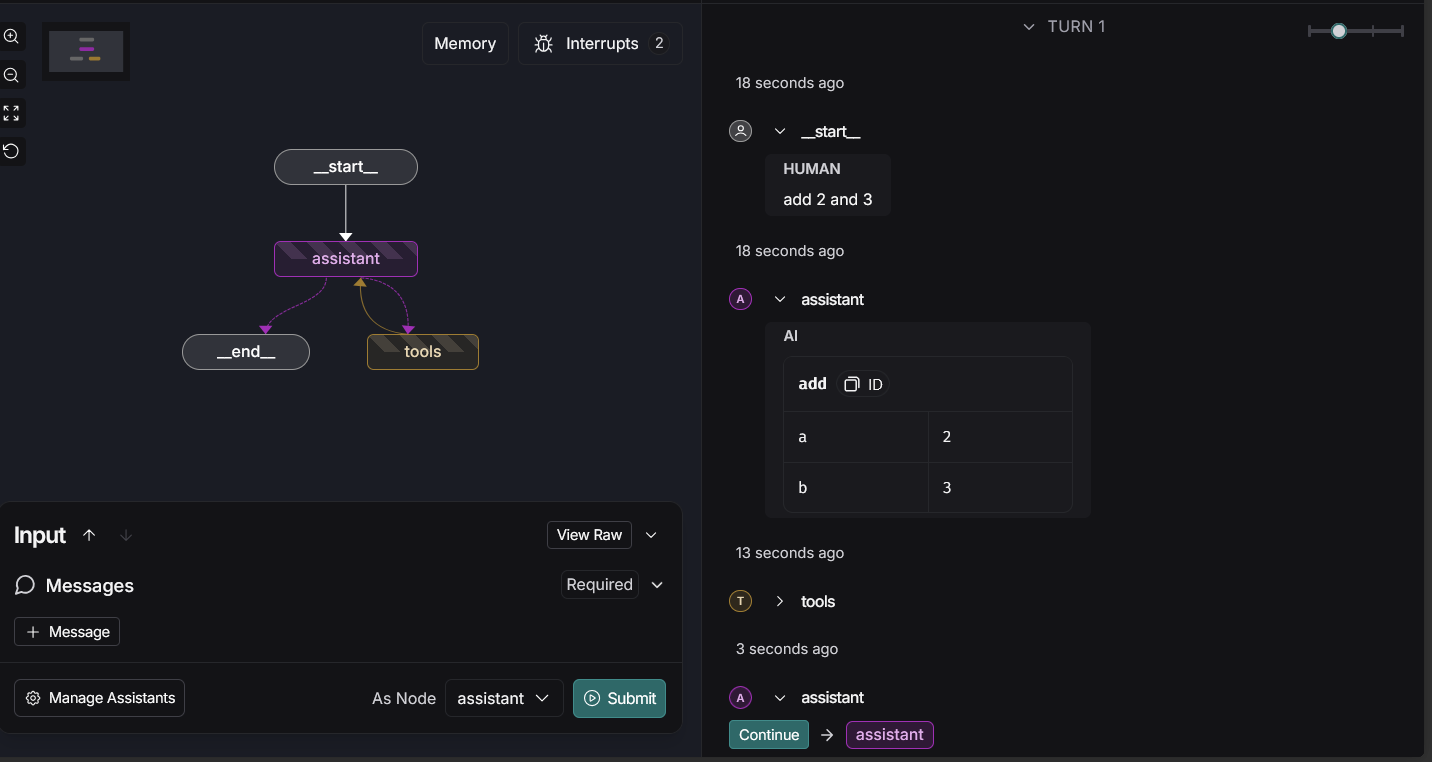

### Breakpoints with LangGraph API

In [14]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [15]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3b822c6e-1721-41d5-ae14-b896dad948c1'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CVG9LOiMtu5JBn3Y6TQa58J1AswLv', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': Non

Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

In [16]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CVG9LOiMtu5JBn3Y6TQa58J1AswLv', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'lc_run--51380d9a-27ed-4acb-ba25-d2f540ffe023-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_VHTrIMXgwYdVWypUIN6sOmuu', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 